# Causal Metric Tensor Extraction

Following Park et al. (2024), we extract the **causal metric tensor** from the model's unembedding matrix. This defines a non-Euclidean inner product that respects semantic structure.

## Background

The causal inner product is defined as:

$$\langle \bar{v}, \bar{v}' \rangle_C = \bar{v}^T M \bar{v}' = \bar{v}^T \text{Cov}(\gamma)^{-1} \bar{v}'$$

where $\gamma$ is the unembedding matrix (vocabulary × hidden_dim) that maps hidden states to token logits.

**Key property:** Causally separable concepts (e.g., English↔French and Male↔Female) are orthogonal under this inner product.

## References

- Park, K., Choe, Y. J., & Veitch, V. (2024). The Linear Representation Hypothesis and the Geometry of Large Language Models. *ICML*.

## Configuration

In [85]:
# Model to extract from
MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"

# Regularization parameter for numerical stability
LAMBDA_REG = 1e-6

# Output path
OUTPUT_PATH = "../data/vectors/causal_metric_tensor_qwen3_4b.pt"

# Device selection
DEVICE = 'auto'  # 'auto', 'cuda', 'mps', or 'cpu'

## Setup

In [86]:
import torch
import numpy as np
from transformers import AutoModelForCausalLM
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime

In [87]:
# Device setup
if DEVICE == 'auto':
    if torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')
else:
    device = torch.device(DEVICE)

print(f"Using device: {device}")

Using device: mps


## Load Model

In [88]:
print(f"Loading {MODEL_NAME}...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map=device,
)
model.eval()
print(f"Model loaded on {device}")
print(f"Hidden dimension: {model.config.hidden_size}")
print(f"Vocabulary size: {model.config.vocab_size}")

Loading Qwen/Qwen3-4B-Instruct-2507...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Extract Unembedding Matrix

The unembedding matrix $\Gamma$ maps hidden states to logits over the vocabulary:

$$\text{logits} = \Gamma h$$

where $\Gamma \in \mathbb{R}^{V \times d}$ (vocab_size × hidden_dim).

In [ ]:
# Extract unembedding matrix (typically model.lm_head.weight)
gamma = model.lm_head.weight.data.to(dtype=torch.float32, device=device)

vocab_size, hidden_dim = gamma.shape
print(f"Unembedding matrix shape: {gamma.shape}")
print(f"Dtype: {gamma.dtype}")
print(f"Device: {gamma.device}")

Unembedding matrix shape: torch.Size([151936, 2560])
Dtype: torch.float32
Device: mps:0


## Compute Covariance Matrix

We compute the covariance of the unembedding vectors across the vocabulary:

$$\text{Cov}(\gamma) = \frac{1}{V} \sum_{i=1}^{V} (\gamma_i - \mu)(\gamma_i - \mu)^T$$

where $\mu = \frac{1}{V} \sum_{i=1}^{V} \gamma_i$ is the mean unembedding vector.

In [ ]:
# Compute mean
mu = gamma.mean(dim=0, keepdim=True)  # [1, hidden_dim]
print(f"Mean unembedding vector shape: {mu.shape}")

# Center the data
gamma_centered = gamma - mu  # [vocab_size, hidden_dim]

# Compute covariance: Cov = (1/V) * Γ^T Γ
cov_gamma = (gamma_centered.T @ gamma_centered) / vocab_size  # [hidden_dim, hidden_dim]
print(f"Covariance matrix shape: {cov_gamma.shape}")

Mean unembedding vector shape: torch.Size([1, 2560])
Covariance matrix shape: torch.Size([2560, 2560])


## Analyze Condition Number

Before inversion, we check the **condition number** to assess numerical stability:

$$\kappa = \frac{\lambda_{\max}}{\lambda_{\min}}$$

High condition numbers (> 10⁶) indicate ill-conditioning and justify regularization.

In [ ]:
# Compute eigenvalues for condition number check
print("Computing eigenvalues...")

# Graceful fallback for devices that don't support eigvalsh (e.g., MPS)
try:
    eigenvalues = torch.linalg.eigvalsh(cov_gamma)  # Hermitian eigenvalue solver
except NotImplementedError:
    print(f"⚠️  eigvalsh not supported on {device}, falling back to CPU")
    eigenvalues = torch.linalg.eigvalsh(cov_gamma.cpu()).to(device)

lambda_max = eigenvalues.max().item()
lambda_min = eigenvalues.min().item()
condition_number = lambda_max / lambda_min

print(f"\nEigenvalue statistics:")
print(f"  Max eigenvalue: {lambda_max:.6e}")
print(f"  Min eigenvalue: {lambda_min:.6e}")
print(f"  Condition number: {condition_number:.6e}")

if condition_number > 1e6:
    print(f"\n⚠️  High condition number detected - regularization is necessary")
else:
    print(f"\n✓ Moderate condition number - regularization still recommended as standard practice")

Computing eigenvalues...
⚠️  eigvalsh not supported on mps, falling back to CPU

Eigenvalue statistics:
  Max eigenvalue: 1.048713e-02
  Min eigenvalue: 9.613271e-06
  Condition number: 1.090901e+03

✓ Moderate condition number - regularization still recommended as standard practice


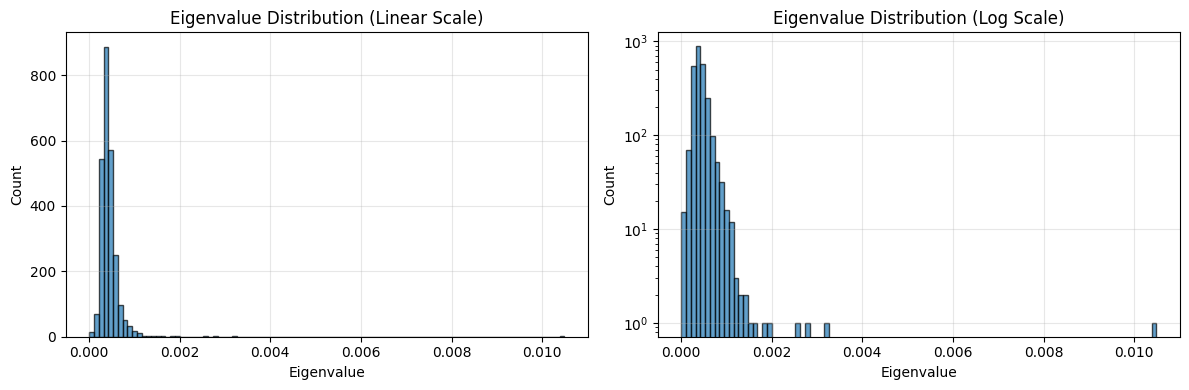

Number of near-zero eigenvalues (< 1e-06): 0


In [ ]:
# Visualize eigenvalue spectrum
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Linear scale
axes[0].hist(eigenvalues.cpu().numpy(), bins=100, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Eigenvalue')
axes[0].set_ylabel('Count')
axes[0].set_title('Eigenvalue Distribution (Linear Scale)')
axes[0].grid(True, alpha=0.3)

# Log scale
axes[1].hist(eigenvalues.cpu().numpy(), bins=100, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Eigenvalue')
axes[1].set_ylabel('Count')
axes[1].set_title('Eigenvalue Distribution (Log Scale)')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Number of near-zero eigenvalues (< {LAMBDA_REG}): {(eigenvalues < LAMBDA_REG).sum().item()}")

## Compute Causal Metric Tensor

We invert the covariance matrix with **Tikhonov regularization** for numerical stability:

$$M = (\text{Cov}(\gamma) + \lambda I)^{-1}$$

where $\lambda$ is a small regularization parameter (default: 10⁻⁶).

This is standard practice for inverting covariance matrices and prevents numerical instability from near-zero eigenvalues.

In [ ]:
# Add regularization term
cov_regularized = cov_gamma + LAMBDA_REG * torch.eye(hidden_dim, device=device, dtype=torch.float32)

# Invert
print(f"Inverting covariance matrix (with λ={LAMBDA_REG})...")
M = torch.linalg.inv(cov_regularized)
print(f"Causal metric tensor shape: {M.shape}")
print(f"Dtype: {M.dtype}")

Inverting covariance matrix (with λ=1e-06)...
Causal metric tensor shape: torch.Size([2560, 2560])
Dtype: torch.float32


## Verify Properties

The causal metric tensor should be:
1. **Symmetric**: $M = M^T$
2. **Positive definite**: all eigenvalues > 0

In [ ]:
# Check symmetry
symmetry_error = torch.abs(M - M.T).max().item()
print(f"Symmetry error (max |M - M^T|): {symmetry_error:.6e}")

# Check positive definiteness (with same device fallback)
try:
    M_eigenvalues = torch.linalg.eigvalsh(M)
except NotImplementedError:
    print(f"⚠️  eigvalsh not supported on {device}, falling back to CPU for verification")
    M_eigenvalues = torch.linalg.eigvalsh(M.cpu()).to(device)

min_M_eigenvalue = M_eigenvalues.min().item()
print(f"Minimum eigenvalue of M: {min_M_eigenvalue:.6e}")

if min_M_eigenvalue > 0:
    print("✓ M is positive definite")
else:
    print("⚠️  M has non-positive eigenvalues")

Symmetry error (max |M - M^T|): 2.832031e-02
⚠️  eigvalsh not supported on mps, falling back to CPU for verification
Minimum eigenvalue of M: 9.534717e+01
✓ M is positive definite


### Interpretation

These metrics tell us about the **geometry of semantic space** as induced by the causal metric tensor:

- **Distance from identity**: Quantifies how much the causal metric warps space compared to Euclidean geometry
- **Participation ratio**: Reveals whether semantic meaning lives in a lower-dimensional submanifold (like a "sphere of well-behaved semantics" embedded in chaos)
- **Eigenvalue spectrum**: Shows which directions are stretched (large λ) vs compressed (small λ) — directions with large eigenvalues are "emphasized" by the causal metric

**Connection to manifold hypothesis:** If the effective dimensionality is much lower than the nominal dimension (2560), this suggests that meaningful representations live on a Riemannian submanifold — exactly the "sphere floating in chaos" intuition!

## Discrete Curvature Estimation

Now for the fun part: **Does the semantic manifold have curvature?**

We'll use **Forman-Ricci curvature** — a discrete curvature measure that works on graphs without requiring smooth derivatives.

### Background

- **Positive curvature** (κ > 0): Sphere-like, locally clustered
- **Negative curvature** (κ < 0): Hyperbolic, locally tree-like  
- **Zero curvature** (κ ≈ 0): Flat, locally Euclidean

We'll sample tokens, build a k-NN graph using the causal metric, and compute Forman-Ricci curvature on edges.

In [ ]:
### Helper: Compute Causal Distances

def compute_causal_distances(embeddings, M_matrix):
    """
    Compute pairwise distances using causal metric: d(x,y) = sqrt((x-y)^T M (x-y))
    
    Args:
        embeddings: [n_samples, hidden_dim] tensor
        M_matrix: [hidden_dim, hidden_dim] metric tensor
    
    Returns:
        distances: [n_samples, n_samples] pairwise distance matrix
    """
    n = embeddings.shape[0]
    distances = torch.zeros(n, n, device=embeddings.device, dtype=embeddings.dtype)
    
    # Compute distances in batches to avoid memory issues
    batch_size = 100
    for i in range(0, n, batch_size):
        i_end = min(i + batch_size, n)
        for j in range(0, n, batch_size):
            j_end = min(j + batch_size, n)
            
            # Compute differences [batch_i, batch_j, hidden_dim]
            diff = embeddings[i:i_end, None, :] - embeddings[None, j:j_end, :]
            
            # d(x,y)^2 = (x-y)^T M (x-y)
            # = diff @ M @ diff^T
            temp = torch.einsum('ijk,kl->ijl', diff, M_matrix)  # [batch_i, batch_j, hidden_dim]
            dist_squared = torch.einsum('ijk,ijk->ij', temp, diff)  # [batch_i, batch_j]
            
            distances[i:i_end, j:j_end] = torch.sqrt(torch.clamp(dist_squared, min=0))
    
    return distances

print("✓ Causal distance function defined")

✓ Causal distance function defined


In [ ]:
### Helper: Build k-NN Graph

def build_knn_graph(distances, k=20):
    """
    Build k-nearest neighbor graph from distance matrix.
    
    Args:
        distances: [n, n] pairwise distance matrix
        k: number of nearest neighbors
    
    Returns:
        edges: list of (i, j, weight) tuples
        n_common_neighbors: dict mapping (i,j) -> count of common neighbors
    """
    n = distances.shape[0]
    
    # Find k nearest neighbors for each node (excluding self)
    neighbors = {}
    for i in range(n):
        # Get distances from node i to all others
        dists = distances[i].cpu().numpy()
        # Exclude self (distance 0)
        dists[i] = np.inf
        # Get indices of k smallest distances
        knn_indices = np.argpartition(dists, k)[:k]
        neighbors[i] = set(knn_indices.tolist())
    
    # Build edge list (symmetric: if i->j then j->i)
    edges = []
    edge_set = set()
    for i in range(n):
        for j in neighbors[i]:
            if (i, j) not in edge_set and (j, i) not in edge_set:
                weight = distances[i, j].item()
                edges.append((i, j, weight))
                edge_set.add((i, j))
    
    # Compute common neighbors for each edge
    n_common_neighbors = {}
    for i, j, w in edges:
        common = len(neighbors[i] & neighbors[j])
        n_common_neighbors[(i, j)] = common
    
    print(f"Built k-NN graph: {n} nodes, {len(edges)} edges (k={k})")
    return edges, n_common_neighbors, neighbors

print("✓ k-NN graph builder defined")

✓ k-NN graph builder defined


In [ ]:
### Helper: Compute Forman-Ricci Curvature

def compute_forman_ricci_curvature(edges, n_common_neighbors, neighbors):
    """
    Compute Forman-Ricci curvature for each edge.
    
    Formula: κ_F(i,j) = w(i,j) · [deg(i) + deg(j) - 2 - 2·(# common neighbors)]
    
    Simplified (unweighted): κ_F(i,j) = deg(i) + deg(j) - 2 - 2·(# common neighbors)
    
    Args:
        edges: list of (i, j, weight) tuples
        n_common_neighbors: dict mapping (i,j) -> count of common neighbors
        neighbors: dict mapping node -> set of neighbors
    
    Returns:
        curvatures: list of curvature values for each edge
    """
    curvatures = []
    
    for i, j, w in edges:
        deg_i = len(neighbors[i])
        deg_j = len(neighbors[j])
        common = n_common_neighbors[(i, j)]
        
        # Forman-Ricci curvature (simplified formula for unweighted graphs)
        kappa = deg_i + deg_j - 2 - 2 * common
        
        curvatures.append(kappa)
    
    return np.array(curvatures)

print("✓ Forman-Ricci curvature function defined")

✓ Forman-Ricci curvature function defined


In [ ]:
### Convergence Test: Increasing Sample Sizes

# Test with progressively larger samples to check convergence
sample_sizes = [500, 1000, 2000, 4000, 8000]
k = 20  # Number of nearest neighbors

results = []

print("Computing curvature for different sample sizes...\n")

for n_samples in sample_sizes:
    print(f"Sample size: {n_samples}")
    
    # Sample random tokens
    token_indices = torch.randperm(vocab_size)[:n_samples]
    sampled_embeddings = gamma[token_indices]  # [n_samples, hidden_dim]
    
    # Compute pairwise causal distances
    print("  Computing distances...")
    distances = compute_causal_distances(sampled_embeddings, M)
    
    # Build k-NN graph
    print("  Building k-NN graph...")
    edges, n_common, neighbors = build_knn_graph(distances, k=k)
    
    # Compute Forman-Ricci curvature
    print("  Computing curvature...")
    curvatures = compute_forman_ricci_curvature(edges, n_common, neighbors)
    
    # Store results
    mean_curv = curvatures.mean()
    std_curv = curvatures.std()
    median_curv = np.median(curvatures)
    
    results.append({
        'n_samples': n_samples,
        'mean': mean_curv,
        'std': std_curv,
        'median': median_curv,
        'min': curvatures.min(),
        'max': curvatures.max(),
        'curvatures': curvatures
    })
    
    print(f"  Mean curvature: {mean_curv:.4f} ± {std_curv:.4f}")
    print(f"  Median curvature: {median_curv:.4f}")
    print()

Computing curvature for different sample sizes...

Sample size: 500
  Computing distances...
  Building k-NN graph...
Built k-NN graph: 500 nodes, 9784 edges (k=20)
  Computing curvature...
  Mean curvature: 0.0773 ± 0.4219
  Median curvature: 0.0000

Sample size: 1000
  Computing distances...
  Building k-NN graph...
Built k-NN graph: 1000 nodes, 19785 edges (k=20)
  Computing curvature...
  Mean curvature: 0.0770 ± 0.3849
  Median curvature: 0.0000

Sample size: 2000
  Computing distances...
  Building k-NN graph...
Built k-NN graph: 2000 nodes, 39633 edges (k=20)
  Computing curvature...
  Mean curvature: 8.2920 ± 8.5545
  Median curvature: 4.0000

Sample size: 4000
  Computing distances...
  Building k-NN graph...
Built k-NN graph: 4000 nodes, 79481 edges (k=20)
  Computing curvature...
  Mean curvature: 15.1645 ± 8.5766
  Median curvature: 14.0000

Sample size: 8000
  Computing distances...
  Building k-NN graph...
Built k-NN graph: 8000 nodes, 158949 edges (k=20)
  Computing curv

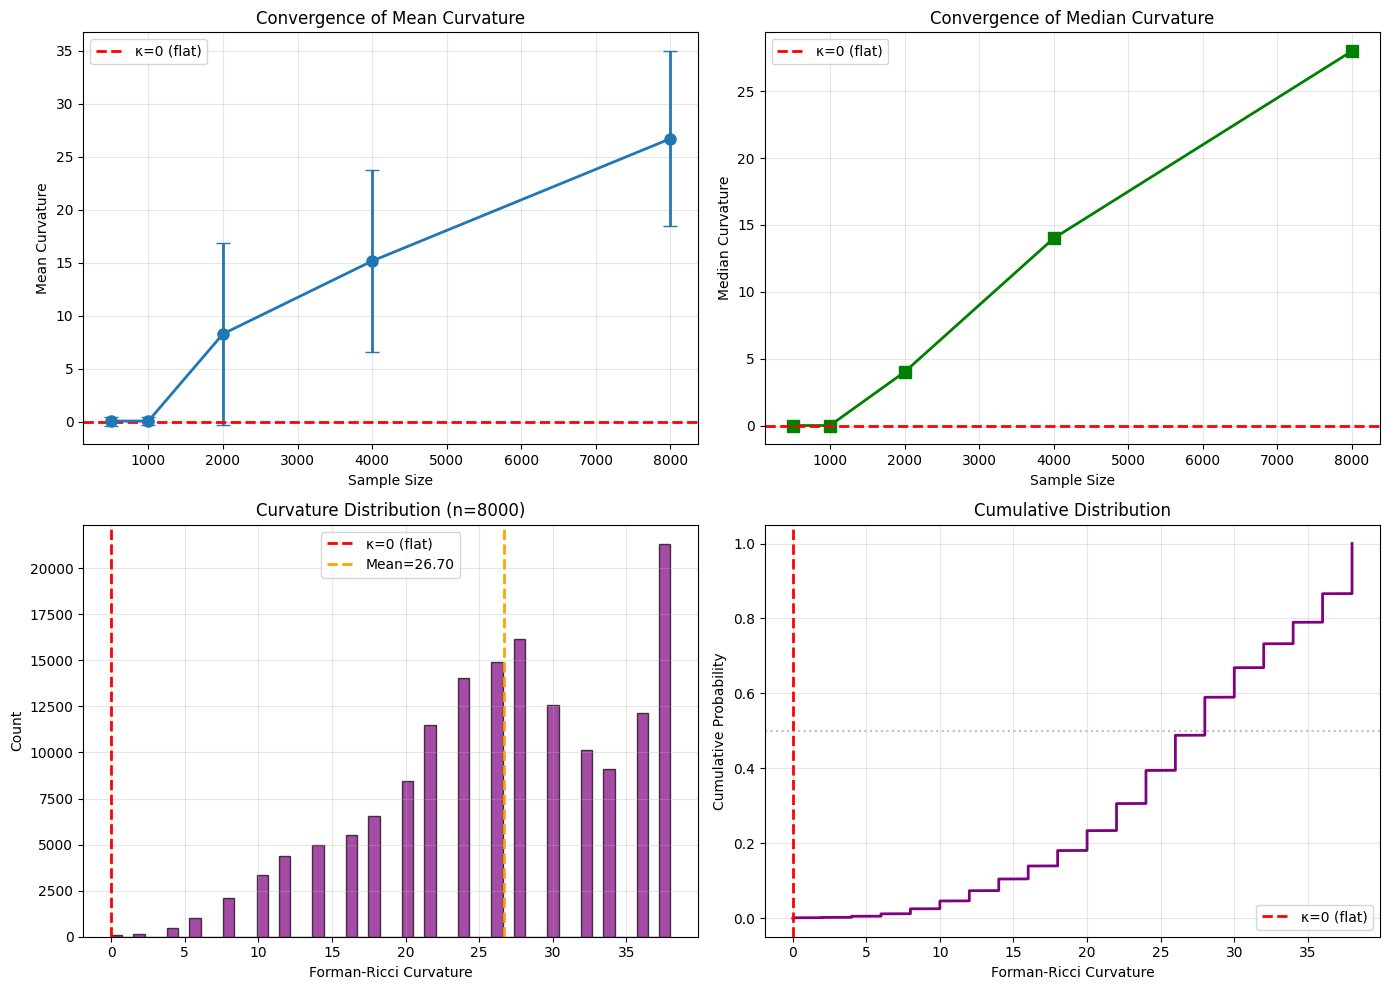

In [ ]:
### Visualize Convergence and Curvature Distribution

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Convergence plot: mean curvature vs sample size
ax = axes[0, 0]
sample_sizes_arr = [r['n_samples'] for r in results]
means = [r['mean'] for r in results]
stds = [r['std'] for r in results]

ax.errorbar(sample_sizes_arr, means, yerr=stds, marker='o', capsize=5, linewidth=2, markersize=8)
ax.set_xlabel('Sample Size')
ax.set_ylabel('Mean Curvature')
ax.set_title('Convergence of Mean Curvature')
ax.grid(True, alpha=0.3)
ax.axhline(0, color='red', linestyle='--', label='κ=0 (flat)', linewidth=2)
ax.legend()

# 2. Convergence plot: median curvature vs sample size
ax = axes[0, 1]
medians = [r['median'] for r in results]

ax.plot(sample_sizes_arr, medians, marker='s', linewidth=2, markersize=8, color='green')
ax.set_xlabel('Sample Size')
ax.set_ylabel('Median Curvature')
ax.set_title('Convergence of Median Curvature')
ax.grid(True, alpha=0.3)
ax.axhline(0, color='red', linestyle='--', label='κ=0 (flat)', linewidth=2)
ax.legend()

# 3. Curvature distribution for largest sample
ax = axes[1, 0]
largest_result = results[-1]
ax.hist(largest_result['curvatures'], bins=50, alpha=0.7, edgecolor='black', color='purple')
ax.set_xlabel('Forman-Ricci Curvature')
ax.set_ylabel('Count')
ax.set_title(f'Curvature Distribution (n={largest_result["n_samples"]})')
ax.axvline(0, color='red', linestyle='--', label='κ=0 (flat)', linewidth=2)
ax.axvline(largest_result['mean'], color='orange', linestyle='--', label=f'Mean={largest_result["mean"]:.2f}', linewidth=2)
ax.grid(True, alpha=0.3)
ax.legend()

# 4. Cumulative distribution
ax = axes[1, 1]
sorted_curvatures = np.sort(largest_result['curvatures'])
cumulative = np.arange(1, len(sorted_curvatures) + 1) / len(sorted_curvatures)
ax.plot(sorted_curvatures, cumulative, linewidth=2, color='purple')
ax.set_xlabel('Forman-Ricci Curvature')
ax.set_ylabel('Cumulative Probability')
ax.set_title('Cumulative Distribution')
ax.axvline(0, color='red', linestyle='--', label='κ=0 (flat)', linewidth=2)
ax.axhline(0.5, color='gray', linestyle=':', alpha=0.5)
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

## Community Structure Analysis

We've established that semantic space is **positively curved** (clustered), but is it:
- **One giant blob** — all tokens in a single connected cluster?
- **Archipelago** — many separate semantic islands?

We'll use **Louvain community detection** to find natural clusters in the k-NN graph and analyze their structure.

In [90]:
import networkx as nx
import community as community_louvain

# Use the largest sample (n=8000) for community detection
largest_idx = -1
n_samples = results[largest_idx]["n_samples"]

# Reconstruct the graph from the largest run
# We need to rebuild it because we didn't save the graph structure
print(f"Running community detection on n={n_samples} sample...")

# Sample the same tokens
token_indices = torch.randperm(vocab_size)[:n_samples]
sampled_embeddings = gamma[token_indices]

# Compute distances and build graph
print("Computing distances...")
distances = compute_causal_distances(sampled_embeddings, M)

print("Building k-NN graph...")
edges, n_common, neighbors = build_knn_graph(distances, k=20)

# Convert to NetworkX graph
print("Converting to NetworkX graph...")
G = nx.Graph()
G.add_nodes_from(range(n_samples))
for i, j, w in edges:
    G.add_edge(i, j, weight=w)

print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Run Louvain community detection
print("Running Louvain community detection...")
partition = community_louvain.best_partition(G, random_state=42)

# Analyze communities
community_ids = list(partition.values())
n_communities = max(community_ids) + 1

# Compute community sizes
from collections import Counter
community_sizes = Counter(community_ids)
sizes = sorted(community_sizes.values(), reverse=True)

# Compute modularity (quality metric for community structure)
modularity = community_louvain.modularity(partition, G)

print(f"=== Community Structure ===")
print(f"Number of communities: {n_communities}")
print(f"Modularity: {modularity:.4f} (higher = better-separated communities)")
print(f"Community sizes:")
print(f"  Largest: {sizes[0]} tokens ({sizes[0]/n_samples:.1%})")
if len(sizes) > 1:
    print(f"  2nd largest: {sizes[1]} tokens ({sizes[1]/n_samples:.1%})")
if len(sizes) > 2:
    print(f"  3rd largest: {sizes[2]} tokens ({sizes[2]/n_samples:.1%})")
print(f"  Smallest: {sizes[-1]} tokens")
print(f"  Mean: {np.mean(sizes):.1f} tokens")
print(f"  Median: {np.median(sizes):.1f} tokens")

# Check connectivity
is_connected = nx.is_connected(G)
if is_connected:
    print(f"✓ Graph is fully connected (all tokens reachable from all others)")
else:
    n_components = nx.number_connected_components(G)
    print(f"⚠️  Graph has {n_components} disconnected components")

Running community detection on n=8000 sample...
Computing distances...
Building k-NN graph...
Built k-NN graph: 8000 nodes, 159053 edges (k=20)
Converting to NetworkX graph...
Graph: 8000 nodes, 159053 edges
Running Louvain community detection...
=== Community Structure ===
Number of communities: 4
Modularity: 0.4936 (higher = better-separated communities)
Community sizes:
  Largest: 2264 tokens (28.3%)
  2nd largest: 2151 tokens (26.9%)
  3rd largest: 1968 tokens (24.6%)
  Smallest: 1617 tokens
  Mean: 2000.0 tokens
  Median: 2059.5 tokens
✓ Graph is fully connected (all tokens reachable from all others)


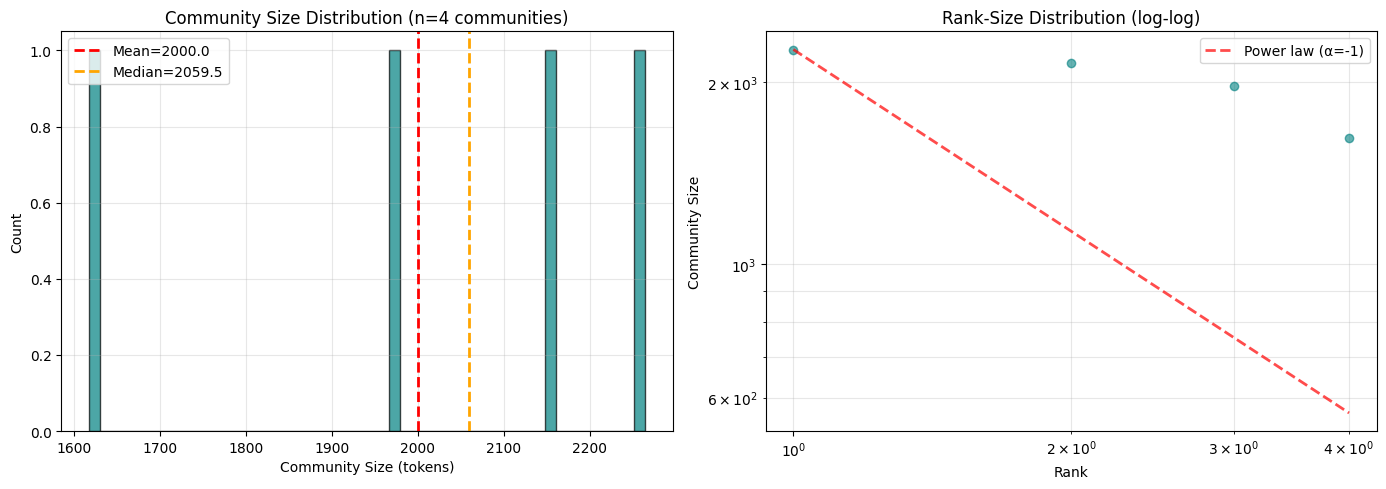

=== Interpretation ===
Semantic space has FEW LARGE CLUSTERS — 4 major semantic regions.


In [91]:
# Visualize community size distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Community size histogram
ax = axes[0]
ax.hist(sizes, bins=50, alpha=0.7, edgecolor='black', color='teal')
ax.set_xlabel('Community Size (tokens)')
ax.set_ylabel('Count')
ax.set_title(f'Community Size Distribution (n={n_communities} communities)')
ax.axvline(np.mean(sizes), color='red', linestyle='--', label=f'Mean={np.mean(sizes):.1f}', linewidth=2)
ax.axvline(np.median(sizes), color='orange', linestyle='--', label=f'Median={np.median(sizes):.1f}', linewidth=2)
ax.grid(True, alpha=0.3)
ax.legend()

# 2. Log-log plot to check for power law
ax = axes[1]
rank = np.arange(1, len(sizes) + 1)
ax.loglog(rank, sizes, marker='o', linestyle='none', alpha=0.6, color='teal')
ax.set_xlabel('Rank')
ax.set_ylabel('Community Size')
ax.set_title('Rank-Size Distribution (log-log)')
ax.grid(True, alpha=0.3, which='both')

# Add power law reference line
x_ref = np.array([1.0, float(len(sizes))])
y_ref = sizes[0] * (x_ref ** -1)  # Power law with exponent -1
ax.plot(x_ref, y_ref, 'r--', linewidth=2, alpha=0.7, label='Power law (α=-1)')
ax.legend()

plt.tight_layout()
plt.show()

print(f"=== Interpretation ===")
if n_communities == 1:
    print("Semantic space is ONE GIANT BLOB — all tokens in a single community.")
elif n_communities < 10:
    print(f"Semantic space has FEW LARGE CLUSTERS — {n_communities} major semantic regions.")
elif sizes[0] / n_samples > 0.5:
    print(f"ONE DOMINANT CLUSTER with {n_communities-1} smaller satellite communities.")
elif np.std(sizes) / np.mean(sizes) > 1.0:
    print(f"HETEROGENEOUS ARCHIPELAGO — {n_communities} communities with highly variable sizes.")
else:
    print(f"MANY RELATIVELY UNIFORM CLUSTERS — {n_communities} communities of similar size.")

## Analyze Metric Tensor Properties

Now that we have M, let's characterize its geometric properties to understand what kind of space it defines.

In [92]:
### 1. Comparison to Euclidean (Identity) Metric

# The identity matrix represents Euclidean space (δ_ij)
I = torch.eye(hidden_dim, device=device, dtype=torch.float32)

# Compute distance from identity using Frobenius norm
diff = M - I
frobenius_distance = torch.norm(diff, p='fro').item()
frobenius_norm_I = torch.norm(I, p='fro').item()
relative_distance = frobenius_distance / frobenius_norm_I

print("Comparison to Euclidean (Identity) Metric:")
print(f"  Frobenius distance ||M - I||_F: {frobenius_distance:.6e}")
print(f"  Relative distance: {relative_distance:.2%}")
print(f"  (0% = perfectly Euclidean, 100% = one standard deviation away)\n")

# Operator norm (largest singular value of difference)
try:
    operator_norm = torch.linalg.matrix_norm(diff, ord=2).item()
except NotImplementedError:
    print("⚠️  Operator norm not supported on {device}, falling back to CPU")
    operator_norm = torch.linalg.matrix_norm(diff.cpu(), ord=2).item()

print(f"  Operator norm ||M - I||_op: {operator_norm:.6e}")
print(f"  (measures maximum directional stretching/compression)\n")

if relative_distance < 0.1:
    print("✓ M is very close to Euclidean")
elif relative_distance < 0.5:
    print("⚠️  M is moderately non-Euclidean")
else:
    print("⚠️  M is strongly non-Euclidean")

Comparison to Euclidean (Identity) Metric:
  Frobenius distance ||M - I||_F: 1.902269e+05
  Relative distance: 375968.96%
  (0% = perfectly Euclidean, 100% = one standard deviation away)

⚠️  Operator norm not supported on {device}, falling back to CPU
  Operator norm ||M - I||_op: 9.421698e+04
  (measures maximum directional stretching/compression)

⚠️  M is strongly non-Euclidean


In [93]:
### 2. Effective Dimensionality (Participation Ratio)

# The participation ratio measures how many dimensions are "actively used" by the metric
# PR = (Σ λᵢ)² / Σ(λᵢ²)
# - PR ≈ d: all dimensions equally important (isotropic)
# - PR << d: space is effectively lower-dimensional (anisotropic)

sum_eigenvalues = M_eigenvalues.sum().item()
sum_squared_eigenvalues = (M_eigenvalues ** 2).sum().item()
participation_ratio = (sum_eigenvalues ** 2) / sum_squared_eigenvalues

print("Effective Dimensionality:")
print(f"  Nominal dimension: {hidden_dim}")
print(f"  Participation ratio: {participation_ratio:.1f}")
print(f"  Effective dimensionality: {participation_ratio / hidden_dim:.2%} of nominal\n")

if participation_ratio / hidden_dim > 0.8:
    print("✓ Space is nearly isotropic (all dimensions equally important)")
elif participation_ratio / hidden_dim > 0.5:
    print("⚠️  Space is moderately anisotropic (some dimensions more important)")
else:
    print("⚠️  Space is strongly anisotropic (effective dimension much lower than nominal)")

Effective Dimensionality:
  Nominal dimension: 2560
  Participation ratio: 1333.1
  Effective dimensionality: 52.08% of nominal

⚠️  Space is moderately anisotropic (some dimensions more important)


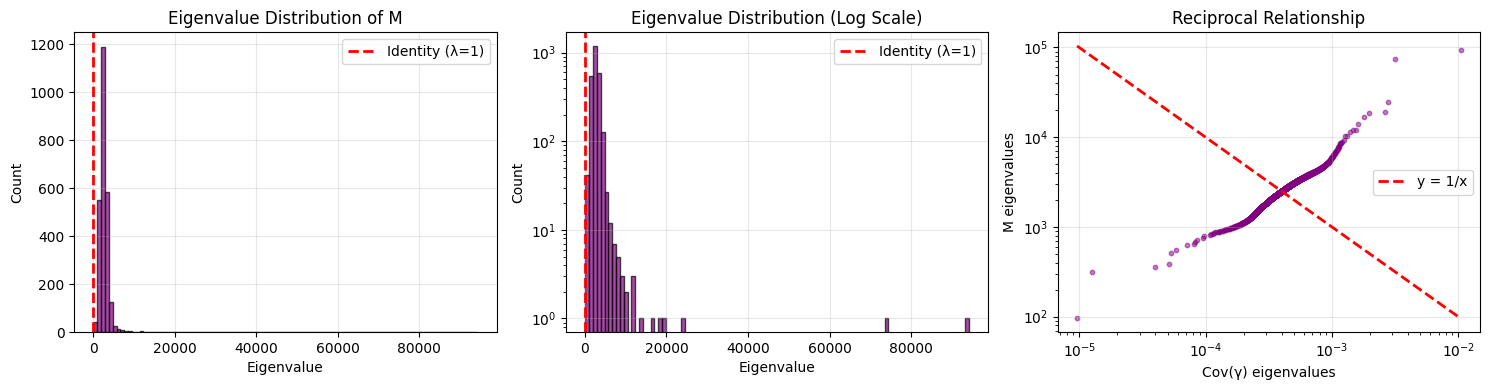


M Eigenvalue Statistics:
  Min: 9.534717e+01
  Max: 9.421814e+04
  Mean: 2.713635e+03
  Median: 2.498257e+03


In [94]:
### 3. Eigenvalue Spectrum of M

# Visualize how M stretches/compresses different directions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Eigenvalue distribution
axes[0].hist(M_eigenvalues.cpu().numpy(), bins=100, alpha=0.7, edgecolor='black', color='purple')
axes[0].set_xlabel('Eigenvalue')
axes[0].set_ylabel('Count')
axes[0].set_title('Eigenvalue Distribution of M')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(1.0, color='red', linestyle='--', label='Identity (λ=1)', linewidth=2)
axes[0].legend()

# Log scale
axes[1].hist(M_eigenvalues.cpu().numpy(), bins=100, alpha=0.7, edgecolor='black', color='purple')
axes[1].set_xlabel('Eigenvalue')
axes[1].set_ylabel('Count')
axes[1].set_title('Eigenvalue Distribution (Log Scale)')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(1.0, color='red', linestyle='--', label='Identity (λ=1)', linewidth=2)
axes[1].legend()

# Comparison: Cov(γ) vs M eigenvalues (should be reciprocal)
axes[2].scatter(eigenvalues.cpu().numpy(), M_eigenvalues.cpu().numpy(), 
                alpha=0.5, s=10, color='purple')
axes[2].set_xlabel('Cov(γ) eigenvalues')
axes[2].set_ylabel('M eigenvalues')
axes[2].set_title('Reciprocal Relationship')
axes[2].set_xscale('log')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

# Add reference line for perfect reciprocal relationship
cov_range = eigenvalues.cpu().numpy()
axes[2].plot(cov_range, 1/cov_range, 'r--', label='y = 1/x', linewidth=2)
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"\nM Eigenvalue Statistics:")
print(f"  Min: {M_eigenvalues.min().item():.6e}")
print(f"  Max: {M_eigenvalues.max().item():.6e}")
print(f"  Mean: {M_eigenvalues.mean().item():.6e}")
print(f"  Median: {M_eigenvalues.median().item():.6e}")

## Save Causal Metric Tensor

In [95]:
# Prepare output
output_data = {
    'M': M,  # [hidden_dim, hidden_dim]
    'cov_gamma': cov_gamma,  # [hidden_dim, hidden_dim]
    'eigenvalues_cov': eigenvalues,  # [hidden_dim]
    'metadata': {
        'model': MODEL_NAME,
        'hidden_dim': hidden_dim,
        'vocab_size': vocab_size,
        'lambda_reg': LAMBDA_REG,
        'condition_number': condition_number,
        'extraction_date': datetime.now().isoformat(),
    }
}

# Create directory if needed
output_path = Path(OUTPUT_PATH)
output_path.parent.mkdir(parents=True, exist_ok=True)

# Save
torch.save(output_data, output_path)
print(f"\nCausal metric tensor saved to: {output_path}")
print(f"File size: {output_path.stat().st_size / 1024**2:.2f} MB")


Causal metric tensor saved to: ../data/vectors/causal_metric_tensor_qwen3_4b.pt
File size: 50.01 MB


## Summary

We have extracted the causal metric tensor $M = \text{Cov}(\gamma)^{-1}$ from the model's unembedding matrix.

**Next steps:**
- Use this tensor to compute causal norms: $\|v\|_C = \sqrt{v^T M v}$
- Compare L2 vs causal norms for layer selection in steering vector extraction
- Investigate whether causal norm identifies a different "best layer" for steering